# TuFT-Chat Supervised Fine-Tuning

This notebook:
- Connects to a running Tuft server
- Loads a chat dataset (no_robots)
- Tokenizes conversations with loss masking
- Trains a LoRA
- Evaluates and plots loss
- Saves weights/checkpoints and runs a sample generation

## 0) Prerequisites
- Tuft server running (e.g. `http://localhost:xxxx`)
- API key available
- Dependencies installed: `tinker datasets transformers matplotlib numpy`


In [2]:
# !pip install -U tinker datasets transformers matplotlib numpy
import os, random
# os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
import numpy as np
import matplotlib.pyplot as plt

import tinker
from tinker import types

from datasets import load_dataset
from dataclasses import dataclass
from transformers import AutoTokenizer

print("Imports OK: tinker =", tinker.__version__ if hasattr(tinker, "__version__") else "unknown")


/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports OK: tinker = 0.8.1


## 1) Configuration

In [3]:
# Tuft server
TINKER_BASE_URL = "http://localhost:8080"
TINKER_API_KEY = "tml-test-key"

# Dataset
DATASET = "no_robots"

# Model
BASE_MODEL = "Qwen/Qwen3-4B-Instruct-2507"
LORA_RANK = 16

# Training
NUM_STEPS = 50
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
MAX_LENGTH = 512

print("=== CONFIG ===")
print("Server:", TINKER_BASE_URL)
print("Dataset:", DATASET)
print("Base model:", BASE_MODEL)
print("LoRA rank:", LORA_RANK)
print("Steps:", NUM_STEPS, "Batch:", BATCH_SIZE, "LR:", LEARNING_RATE, "MaxLen:", MAX_LENGTH)

=== CONFIG ===
Server: http://localhost:8080
Dataset: no_robots
Base model: Qwen/Qwen3-4B-Instruct-2507
LoRA rank: 16
Steps: 50 Batch: 16 LR: 0.0001 MaxLen: 512


## 2) Connect to Tuft server

In [4]:
service_client = tinker.ServiceClient(base_url=TINKER_BASE_URL, api_key=TINKER_API_KEY)
print("ServiceClient created:", service_client)


ServiceClient created: <tinker.ServiceClient object at 0x7f3a8e973da0>


## 3) Load tokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
print("Tokenizer loaded:", type(tokenizer).__name__)
print("eos_token_id:", tokenizer.eos_token_id)

_ids = tokenizer.encode("hello", add_special_tokens=False)
print("Sanity encode('hello') ids[:5] =", _ids[:5], "len=", len(_ids))
print("Sanity decode =", tokenizer.decode(_ids))


Tokenizer loaded: Qwen2TokenizerFast
eos_token_id: 151645
Sanity encode('hello') ids[:5] = [14990] len= 1
Sanity decode = hello


## 4) Tokenization utilities

In [6]:
def tokenize_conversation(messages, tokenizer, max_length: int):
    """Tokenize a conversation and compute per-token loss weights.
    """
    all_tokens = []
    all_weights = []

    for i, msg in enumerate(messages):
        partial = messages[: i + 1]
        text = tokenizer.apply_chat_template(
            partial,
            tokenize=False,
            add_generation_prompt=False,
        )
        tokens = tokenizer.encode(text, add_special_tokens=False)

        prev_len = len(all_tokens)
        new_tokens = tokens[prev_len:]

        is_assistant = msg.get("role") == "assistant"
        weight = 1.0 if is_assistant else 0.0

        all_tokens.extend(new_tokens)
        all_weights.extend([weight] * len(new_tokens))

    if len(all_tokens) > max_length:
        all_tokens = all_tokens[:max_length]
        all_weights = all_weights[:max_length]

    return all_tokens, np.array(all_weights, dtype=np.float32)


def conversation_to_datum(messages, tokenizer, max_length: int) -> types.Datum:
    """Convert a conversation into next-token-prediction Datum with shifted weights."""
    tokens, weights = tokenize_conversation(messages, tokenizer, max_length)
    if len(tokens) < 2:
        raise ValueError("Conversation too short")

    input_tokens = tokens[:-1]
    target_tokens = tokens[1:]
    target_weights = weights[1:]

    return types.Datum(
        model_input=types.ModelInput.from_ints(input_tokens),
        loss_fn_inputs={
            "target_tokens": list(target_tokens),
            "weights": target_weights.tolist(),
        },
    )


# Verification
_debug_msgs = [
    {"role": "user", "content": "Hello!"},
    {"role": "assistant", "content": "Hi, how can I help you?"},
]
_debug_tokens, _debug_w = tokenize_conversation(_debug_msgs, tokenizer, MAX_LENGTH)
print("Tokenization sanity:")
print("  tokens_len =", len(_debug_tokens))
print("  weights_len =", len(_debug_w))
print("  weight_sum =", float(_debug_w.sum()), "nonzero =", int((_debug_w > 0).sum()))
print("  weight_unique =", sorted(set(_debug_w.tolist())))


Tokenization sanity:
  tokens_len = 20
  weights_len = 20
  weight_sum = 13.0 nonzero = 13
  weight_unique = [0.0, 1.0]


## 5) Dataset loader

In [7]:
@dataclass
class ChatDataset:
    """Simple chat dataset with batching."""
    data: list[list[dict]]
    index: int = 0

    def get_batch(self, batch_size: int) -> list[list[dict]]:
        batch = []
        for _ in range(batch_size):
            if self.index >= len(self.data):
                self.index = 0
                random.shuffle(self.data)
            batch.append(self.data[self.index])
            self.index += 1
        return batch

    def __len__(self) -> int:
        return len(self.data)


def load_chat_dataset(dataset_name: str, seed: int = 42):
    random.seed(seed)

    if dataset_name == "no_robots":
        ds = load_dataset("HuggingFaceH4/no_robots")
        train_data = [row["messages"] for row in ds["train"]]
        test_data = [row["messages"] for row in ds["test"]]
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    random.shuffle(train_data)
    return ChatDataset(train_data), ChatDataset(test_data)


train_dataset, test_dataset = load_chat_dataset(DATASET)
print(f"Dataset loaded: {DATASET}")
print(f"Train: {len(train_dataset)} conversations")
print(f"Test:  {len(test_dataset)} conversations")

sample = train_dataset.get_batch(1)[0]
print(f"\nSample conversation ({len(sample)} messages), showing first 3:")
for msg in sample[:3]:
    content = msg["content"][:100] + ("..." if len(msg["content"]) > 100 else "")
    print(f"  [{msg['role']}]: {content}")

Dataset loaded: no_robots
Train: 9500 conversations
Test:  500 conversations

Sample conversation (2 messages), showing first 3:
  [user]: Does Yi view fan fiction positively or negatively? Explain your answer. 

What does Yi say about fan...
  [assistant]: Yi views fan fiction positively. They say it is something to be celebrated and is an interesting, ri...


## 6) Create LoRA training client

In [9]:
training_client = service_client.create_lora_training_client(
    base_model=BASE_MODEL,
    rank=LORA_RANK,
    train_mlp=True,
    train_attn=True,
    train_unembed=True,
)

print("Training client created:", training_client)
print("LoRA config:", {"base_model": BASE_MODEL, "rank": LORA_RANK})

Training client created: <tinker.TrainingClient object at 0x7f39f6230710>
LoRA config: {'base_model': 'Qwen/Qwen3-4B-Instruct-2507', 'rank': 16}


## 7) Train loop (SFT)

In [10]:
def compute_weighted_nll_from_outputs(loss_fn_outputs, datums):
    total_loss = 0.0
    total_weight =  0.0
    for i, out in enumerate(loss_fn_outputs):
        logprobs = out["logprobs"]
        if hasattr(logprobs, "tolist"):
            logprobs = logprobs.tolist()

        w = datums[i].loss_fn_inputs["weights"]
        if hasattr(w, "tolist"):
            w = w.tolist()

        for lp, wt in zip(logprobs, w):
            total_loss += -lp * wt
            total_weight += wt
    return total_loss / max(total_weight, 1.0)


metrics_history = []

print(f"Starting SFT training: {NUM_STEPS} steps")
print(f"Batch: {BATCH_SIZE}, LR: {LEARNING_RATE}\n")

for step in range(NUM_STEPS):
    batch = train_dataset.get_batch(BATCH_SIZE)

    datums = []
    for messages in batch:
        try:
            datums.append(conversation_to_datum(messages, tokenizer, MAX_LENGTH))
        except Exception:
            continue

    print(f"[debug] step={step} valid_datums={len(datums)}/{BATCH_SIZE}")
    if not datums:
        continue

    fwdbwd_result = training_client.forward_backward(
        datums,
        loss_fn="cross_entropy",
    ).result()

    loss = compute_weighted_nll_from_outputs(fwdbwd_result.loss_fn_outputs, datums)

    training_client.optim_step(types.AdamParams(learning_rate=LEARNING_RATE)).result()

    metrics_history.append({"step": step, "loss": loss})

    if step % 10 == 0 or step == NUM_STEPS - 1:
        print(f"Step {step:3d}: loss={loss:.4f}")

print("\nTraining complete!")
if metrics_history:
    print(f"Initial loss: {metrics_history[0]['loss']:.4f}")
    print(f"Final loss:   {metrics_history[-1]['loss']:.4f}")


Starting SFT training: 50 steps
Batch: 16, LR: 0.0001

[debug] step=0 valid_datums=16/16
Step   0: loss=3.2983
[debug] step=1 valid_datums=16/16
[debug] step=2 valid_datums=16/16
[debug] step=3 valid_datums=16/16
[debug] step=4 valid_datums=16/16
[debug] step=5 valid_datums=16/16
[debug] step=6 valid_datums=16/16
[debug] step=7 valid_datums=16/16
[debug] step=8 valid_datums=16/16
[debug] step=9 valid_datums=16/16
[debug] step=10 valid_datums=16/16
Step  10: loss=2.4225
[debug] step=11 valid_datums=16/16
[debug] step=12 valid_datums=16/16
[debug] step=13 valid_datums=16/16
[debug] step=14 valid_datums=16/16
[debug] step=15 valid_datums=16/16
[debug] step=16 valid_datums=16/16
[debug] step=17 valid_datums=16/16
[debug] step=18 valid_datums=16/16
[debug] step=19 valid_datums=16/16
[debug] step=20 valid_datums=16/16
Step  20: loss=1.9404
[debug] step=21 valid_datums=16/16
[debug] step=22 valid_datums=16/16
[debug] step=23 valid_datums=16/16
[debug] step=24 valid_datums=16/16
[debug] step=2

## 8) Evaluate on test set

In [11]:
test_batch = test_dataset.get_batch(min(16, len(test_dataset)))

test_datums = []
for messages in test_batch:
    try:
        test_datums.append(conversation_to_datum(messages, tokenizer, MAX_LENGTH))
    except Exception:
        continue

print("Test valid_datums:", len(test_datums), "/", len(test_batch))

if test_datums:
    forward_result = training_client.forward(
        test_datums,
        loss_fn="cross_entropy",
    ).result()

    test_loss = compute_weighted_nll_from_outputs(forward_result.loss_fn_outputs, test_datums)
    print(f"Test NLL: {test_loss:.4f}")
else:
    print("No valid test samples")


Test valid_datums: 16 / 16
Test NLL: 2.0844


## 9) Plot training loss

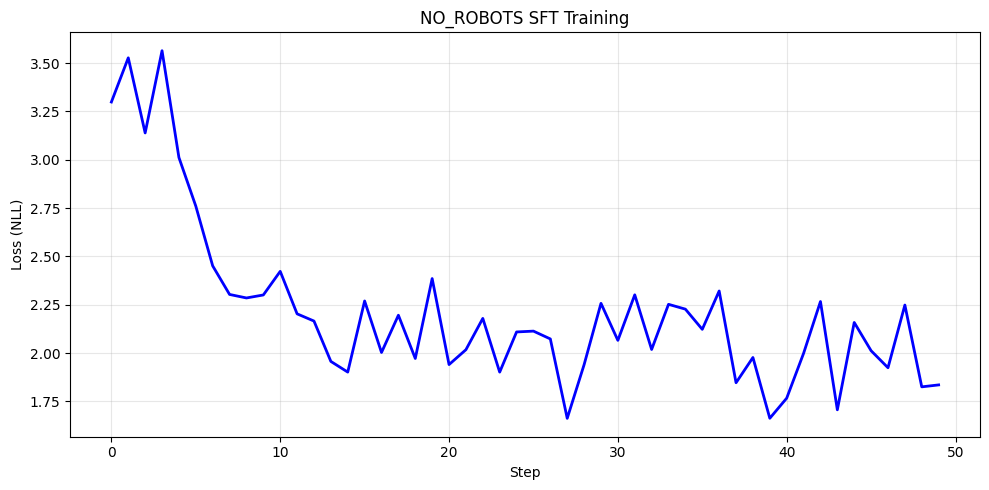

Saved plot: no_robots_training.png exists = True


In [12]:
import os

if metrics_history:
    steps = [m["step"] for m in metrics_history]
    losses = [m["loss"] for m in metrics_history]

    plt.figure(figsize=(10, 5))
    plt.plot(steps, losses, "b-", linewidth=2)
    plt.xlabel("Step")
    plt.ylabel("Loss (NLL)")
    plt.title(f"{DATASET.upper()} SFT Training")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    fig_path = f"{DATASET}_training.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()

print("Saved plot:", fig_path, "exists =", os.path.exists(fig_path) if 'fig_path' in globals() else False)


## 10) Save weights + sample generation + save checkpoint

In [13]:
sampling_path = training_client.save_weights_for_sampler(
    name=f"{DATASET}-sft-demo"
).result().path

print("Sampling checkpoint path:", sampling_path)

sampling_client = service_client.create_sampling_client(model_path=sampling_path)
print("Sampling client created:", sampling_client)

test_messages = [
    {"role": "user", "content": "Write a haiku about programming."}
]

prompt_text = tokenizer.apply_chat_template(
    test_messages,
    tokenize=False,
    add_generation_prompt=True,
)
prompt_tokens = tokenizer.encode(prompt_text, add_special_tokens=False)
print("Prompt tokens len:", len(prompt_tokens))

sample_result = sampling_client.sample(
    prompt=types.ModelInput.from_ints(prompt_tokens),
    num_samples=1,
    sampling_params=types.SamplingParams(
        max_tokens=128,
        temperature=0.7,
        stop_token_ids=[tokenizer.eos_token_id],
    ),
)
sample_result = sample_result.result() if hasattr(sample_result, "result") else sample_result

response = tokenizer.decode(sample_result.sequences[0].tokens)

print("=== Generation ===")
print("User: Write a haiku about programming.")
print("Assistant:", response[:500])
print("Response chars:", len(response))

checkpoint = training_client.save_state(name=f"{DATASET}-sft-final").result()
print("Checkpoint saved:", checkpoint.path)

Sampling checkpoint path: tinker://ca896958-06e3-4ebc-990a-cc29fb933bbf/sampler_weights/no_robots-sft-demo
Sampling client created: <tinker.SamplingClient object at 0x7f3a8d82e930>
Prompt tokens len: 15
=== Generation ===
User: Write a haiku about programming.
Assistant: Now I can do it all, 
And build a working app, 
But it still crashes.<|im_end|>
Response chars: 79
Checkpoint saved: tinker://ca896958-06e3-4ebc-990a-cc29fb933bbf/weights/no_robots-sft-final
